In [1]:
import os
from skimage import io
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from tensorflow import keras

from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
import tensorflow as tf
#tf.config.gpu.set_per_process_memory_fraction(0.75)
#tf.config.gpu.set_per_process_memory_growth(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 20
l = 7 # no of layers in dense block
num_filter = 30  # growth rate k
compression = 1
dropout_rate = 0.2

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
#x_train = tf.cast(X_train, dtype=tf.float32)
#x_test = tf.cast(X_test, dtype=tf.float32)


#tf.dtypes.cast(X_train,tf.int32, name=x_train)
#tf.dtypes.cast(X_test,tf.int32, name=x_test)


# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
import pandas as pd
import numpy as np
'''def preprocess_data(data_set):
    mean = np.array([125.3, 123.0, 113.9])
    std = np.array([63.0, 62.1, 66.7])

    data_set -= mean
    data_set /= std
    return data_set

x_train = preprocess_data(x_train)
x_test = preprocess_data(x_test)'''


x_train /= 255
x_test /= 255

In [6]:
x_train.shape

(50000, 32, 32, 3)

In [7]:
x_test.shape

(10000, 32, 32, 3)

In [0]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, DepthwiseConv2D
from keras.layers import Concatenate
from keras.models import load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.10)


In [9]:
# Data augementation
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.10
)

datagen_train.fit(x_train)

'''train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      shear_range=0.3,
      zoom_range=0.1,
      width_shift_range=0.125,
      height_shift_range=0.125,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
        x_train,y_train,
        batch_size=batch_size,
        shuffle=True)
 
validation_generator = validation_datagen.flow(
        x_val,y_val,
        batch_size=batch_size,
        shuffle=True)
#datagen_train.fit(x_train)'''

"train_datagen = ImageDataGenerator(\n      rescale=1./255,\n      rotation_range=20,\n      shear_range=0.3,\n      zoom_range=0.1,\n      width_shift_range=0.125,\n      height_shift_range=0.125,\n      horizontal_flip=True,\n      fill_mode='nearest')\nvalidation_datagen = ImageDataGenerator(rescale=1./255)\n\ntrain_generator = train_datagen.flow(\n        x_train,y_train,\n        batch_size=batch_size,\n        shuffle=True)\n \nvalidation_generator = validation_datagen.flow(\n        x_val,y_val,\n        batch_size=batch_size,\n        shuffle=True)\n#datagen_train.fit(x_train)"

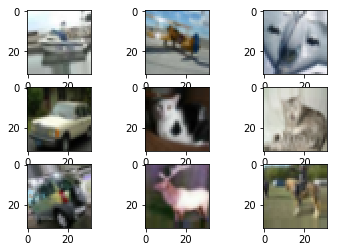

In [10]:
for X_batch, y_batch in datagen_train.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
    plt.show()
    break

In [0]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Block
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [12]:
#num_filter = 12
#dropout_rate = 0.2
#l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


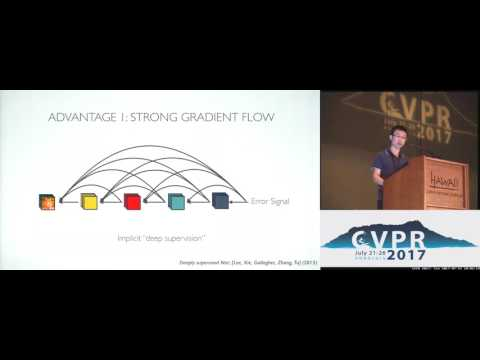

In [13]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [14]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 30)   810         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 30)   120         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 30)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',#SGD(lr=0.1, momentum=0.9, decay=0.0001, nesterov=True),
              metrics=['accuracy'])

In [16]:
'''reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.000001)

early_stop = EarlyStopping(monitor = "val_loss", patience = 10)
def decay_fn(epoch, lr):
    if epoch < 50:
        return 0.001
    elif epoch >= 50 and epoch < 75:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(decay_fn)

csv_logger = CSVLogger('training.log')
filepath = "{epoch:03d}-{val_acc:.3f}.hdf5"
model_chkpt = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only=True, verbose = 1)'''

'reduce_lr = ReduceLROnPlateau(monitor = \'val_loss\', factor = 0.1, patience = 5, min_lr = 0.000001)\n\nearly_stop = EarlyStopping(monitor = "val_loss", patience = 10)\ndef decay_fn(epoch, lr):\n    if epoch < 50:\n        return 0.001\n    elif epoch >= 50 and epoch < 75:\n        return 0.0001\n    else:\n        return 0.00001\n\nlr_scheduler = LearningRateScheduler(decay_fn)\n\ncsv_logger = CSVLogger(\'training.log\')\nfilepath = "{epoch:03d}-{val_acc:.3f}.hdf5"\nmodel_chkpt = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only=True, verbose = 1)'

In [17]:
%%time
history = model.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=(len(x_train)/batch_size)*5,
    epochs=epochs,
    verbose = 1,
    validation_data=(x_val, y_val),
    #callbacks = [lr_scheduler, csv_logger, model_chkpt]
)


Epoch 1/20
3516/3515 [==============================] - 819s 233ms/step - loss: 1.0965 - acc: 0.6052 - val_loss: 0.9847 - val_acc: 0.6976
Epoch 2/20
3516/3515 [==============================] - 805s 229ms/step - loss: 0.6824 - acc: 0.7612 - val_loss: 0.8113 - val_acc: 0.7600
Epoch 3/20
3516/3515 [==============================] - 805s 229ms/step - loss: 0.5546 - acc: 0.8075 - val_loss: 0.8002 - val_acc: 0.7836
Epoch 4/20
3516/3515 [==============================] - 805s 229ms/step - loss: 0.4844 - acc: 0.8322 - val_loss: 0.5801 - val_acc: 0.8254
Epoch 5/20
3516/3515 [==============================] - 808s 230ms/step - loss: 0.4302 - acc: 0.8503 - val_loss: 0.5544 - val_acc: 0.8374
Epoch 6/20
3516/3515 [==============================] - 807s 230ms/step - loss: 0.3908 - acc: 0.8637 - val_loss: 0.4420 - val_acc: 0.8712
Epoch 7/20
3516/3515 [==============================] - 805s 229ms/step - loss: 0.3607 - acc: 0.8742 - val_loss: 0.4671 - val_acc: 0.8590
Epoch 8/20
3516/3515 [============

In [20]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 30)   810         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 30)   120         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 30)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 9s 950us/sample - loss: 0.3658 - acc: 0.8987
Test loss: 0.3657665253818035
Test accuracy: 0.8987


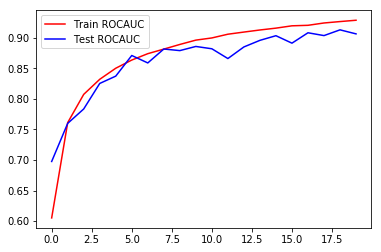

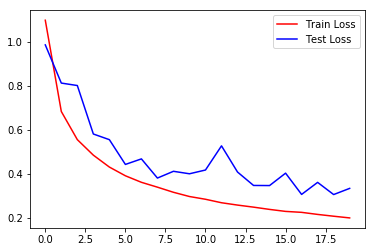

In [21]:
plt.plot(history.history['acc'], 'r')
plt.plot(history.history['val_acc'], 'b')
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})
plt.show()


plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

Here train and test AUC as well as loss value are very near >90% . TheAUC achieve more than 90& with just 20 epochs. overfitting chance is very low

In [19]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk
